In [1]:
import os 
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

from GRU_pipeline import DataHolder, paths, MultiModalDicDataset, GRUModel, pad_collate, eval_on_val, train_one_epoch
from models import GRUMultiModal, GRUBiModal, BertClassif

/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DH = DataHolder(**paths, none_as_class=False)

train_test_1 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 1, none_count = 2000, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 2, none_count = 2000, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x) ** 2 for x in class_weights])

train_dataset_1 = MultiModalDicDataset(**train_test_1['data'])
test_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["test_dic_openface"], train_dic_opensmile = train_test_1["data"]["test_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["valid_dic_openface"], train_dic_opensmile = train_test_1["data"]["valid_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = MultiModalDicDataset(**train_test_2['data'])
test_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["test_dic_openface"], train_dic_opensmile = train_test_2["data"]["test_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["valid_dic_openface"], train_dic_opensmile = train_test_2["data"]["valid_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [4]:
multi_modal_params = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":2, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":2, 
            "output_dim":5, 
            "dropout_prob":.1,
            "activation":"sigmoid"}
AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":2, "output_dim":5, "dropout_prob":.1, "activation":"sigmoid"}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":2, "output_dim":5, "dropout_prob":.1, "activation":"sigmoid"}
TEXTPARAMS = {"embeddings_dim" : 768, "hidden_dim" : 768, "output_dim" : 5, "activation":"sigmoid"}

multi_modal_model = GRUMultiModal(**multi_modal_params)
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
txt_model = BertClassif(**TEXTPARAMS)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = video_model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
model_l = [multi_modal_model, audio_model, video_model, txt_model] #
modality_l = ["", "audio", "video", ""] # 

save_dir = "2layer-32hiddendim-5class-sigmoid-42/"

if not os.path.isdir("models/" + save_dir):
    os.mkdir("models/" + save_dir)

for model_, modality_ in zip(model_l, modality_l):
    stagnation= 0
    best_vloss = 1000
    optimizer = torch.optim.Adam(params = model_.parameters(), lr = 3e-5)
    for epoch in tqdm(range(EPOCHS), total = EPOCHS):

        curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
        if epoch % 30 == 0:
            print("EPOCH {}:".format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        video_model.train(True)
        hist_train_loss, hist_val_loss, stagnation, best_vloss = train_one_epoch(
            epoch, model_, criterion, train_loader_1, train_loader_2, val_loader_1, val_loader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss, opt = optimizer, modality = modality_, save_dir = "models/" + save_dir
        )

        if stagnation > 4:
            break

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:07<58:57,  7.09s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 3.441110134124756, Val loss = 3.4865059852600098


  6%|▌         | 30/500 [02:00<35:13,  4.50s/it]

EPOCH 31:


  6%|▌         | 31/500 [02:05<35:51,  4.59s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7144855856895447, Val loss = 0.7719845771789551


 12%|█▏        | 60/500 [04:18<46:46,  6.38s/it]

EPOCH 61:


 12%|█▏        | 61/500 [04:22<40:27,  5.53s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.6141862273216248, Val loss = 0.6820397973060608


 18%|█▊        | 90/500 [06:40<24:38,  3.61s/it]  

EPOCH 91:


 18%|█▊        | 91/500 [06:45<27:03,  3.97s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.5664384961128235, Val loss = 0.6244626045227051


 24%|██▍       | 120/500 [08:50<28:34,  4.51s/it]

EPOCH 121:


 24%|██▍       | 121/500 [08:54<26:57,  4.27s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.5158464908599854, Val loss = 0.5788013935089111


 30%|███       | 150/500 [10:50<21:55,  3.76s/it]

EPOCH 151:


 30%|███       | 151/500 [10:54<21:56,  3.77s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.48495280742645264, Val loss = 0.5828675627708435


 36%|███▌      | 180/500 [12:49<20:08,  3.78s/it]

EPOCH 181:


 36%|███▌      | 181/500 [12:53<19:48,  3.73s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.44292551279067993, Val loss = 0.5710870623588562


 42%|████▏     | 210/500 [14:38<17:33,  3.63s/it]

EPOCH 211:


 42%|████▏     | 211/500 [14:42<17:52,  3.71s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.4205687642097473, Val loss = 0.5522103309631348


 48%|████▊     | 240/500 [16:26<15:17,  3.53s/it]

EPOCH 241:


 48%|████▊     | 241/500 [16:29<15:28,  3.58s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.3967447578907013, Val loss = 0.5785520076751709


 54%|█████▍    | 270/500 [18:16<13:28,  3.52s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [18:20<13:35,  3.56s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.3818706274032593, Val loss = 0.5686637759208679


 60%|██████    | 300/500 [20:12<12:24,  3.72s/it]

EPOCH 301:


 60%|██████    | 301/500 [20:16<12:32,  3.78s/it]

EPOCH 301:
Training epoch 300 :
Train loss = 0.36023810505867004, Val loss = 0.5926017165184021


 66%|██████▌   | 330/500 [22:03<11:14,  3.97s/it]

EPOCH 331:


 66%|██████▌   | 331/500 [22:08<11:21,  4.03s/it]

EPOCH 331:
Training epoch 330 :
Train loss = 0.3333449065685272, Val loss = 0.5842875838279724


 72%|███████▏  | 360/500 [23:58<08:40,  3.72s/it]

EPOCH 361:


 72%|███████▏  | 360/500 [24:01<09:20,  4.00s/it]


EPOCH 361:
Training epoch 360 :
Train loss = 0.3278287649154663, Val loss = 0.6215409636497498


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:02<17:36,  2.12s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 3.4556193351745605, Val loss = 3.485180139541626


  6%|▌         | 30/500 [01:03<15:58,  2.04s/it]

EPOCH 31:


  6%|▌         | 31/500 [01:05<15:50,  2.03s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.699486255645752, Val loss = 0.7371469140052795


 12%|█▏        | 60/500 [02:02<14:27,  1.97s/it]

EPOCH 61:


 12%|█▏        | 61/500 [02:04<14:24,  1.97s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.600121259689331, Val loss = 0.6749730706214905


 18%|█▊        | 90/500 [03:05<13:39,  2.00s/it]

EPOCH 91:


 18%|█▊        | 91/500 [03:07<13:41,  2.01s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.5514337420463562, Val loss = 0.6184237003326416


 24%|██▍       | 120/500 [04:04<12:27,  1.97s/it]

EPOCH 121:


 24%|██▍       | 121/500 [04:06<12:24,  1.96s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.5101630687713623, Val loss = 0.6084092855453491


 30%|███       | 150/500 [05:05<11:30,  1.97s/it]

EPOCH 151:


 30%|███       | 151/500 [05:07<11:23,  1.96s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.47723203897476196, Val loss = 0.6072235703468323


 36%|███▌      | 180/500 [06:05<10:40,  2.00s/it]

EPOCH 181:


 36%|███▌      | 181/500 [06:07<10:41,  2.01s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.46411648392677307, Val loss = 0.5844476819038391


 42%|████▏     | 210/500 [07:06<09:29,  1.96s/it]

EPOCH 211:


 42%|████▏     | 211/500 [07:08<09:31,  1.98s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.4374341666698456, Val loss = 0.5952340960502625


 48%|████▊     | 240/500 [08:09<10:00,  2.31s/it]

EPOCH 241:


 48%|████▊     | 241/500 [08:11<09:47,  2.27s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.4145190119743347, Val loss = 0.6042093634605408


 54%|█████▍    | 270/500 [09:14<07:41,  2.01s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [09:16<07:40,  2.01s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.39029785990715027, Val loss = 0.6220377683639526


 60%|██████    | 300/500 [10:13<06:37,  1.99s/it]

EPOCH 301:


 60%|██████    | 301/500 [10:15<06:39,  2.01s/it]

EPOCH 301:
Training epoch 300 :
Train loss = 0.36960920691490173, Val loss = 0.6045377850532532


 66%|██████▌   | 330/500 [11:13<05:39,  2.00s/it]

EPOCH 331:


 66%|██████▌   | 330/500 [11:15<05:48,  2.05s/it]


EPOCH 331:
Training epoch 330 :
Train loss = 0.36008700728416443, Val loss = 0.6195204257965088


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:02<17:12,  2.07s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 3.466097354888916, Val loss = 3.465955972671509


  6%|▌         | 30/500 [01:00<15:30,  1.98s/it]

EPOCH 31:


  6%|▌         | 31/500 [01:02<15:32,  1.99s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7082136869430542, Val loss = 0.7534030675888062


 12%|█▏        | 60/500 [02:04<14:43,  2.01s/it]

EPOCH 61:


 12%|█▏        | 61/500 [02:06<14:47,  2.02s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.6051512360572815, Val loss = 0.6760932803153992


 18%|█▊        | 90/500 [03:03<13:28,  1.97s/it]

EPOCH 91:


 18%|█▊        | 91/500 [03:05<13:30,  1.98s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.5584191083908081, Val loss = 0.6212576031684875


 24%|██▍       | 120/500 [04:19<12:37,  1.99s/it]

EPOCH 121:


 24%|██▍       | 121/500 [04:21<12:35,  1.99s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.5069268345832825, Val loss = 0.6009538769721985


 30%|███       | 150/500 [05:19<11:34,  1.99s/it]

EPOCH 151:


 30%|███       | 151/500 [05:21<11:16,  1.94s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.469982773065567, Val loss = 0.588169276714325


 36%|███▌      | 180/500 [06:21<10:56,  2.05s/it]

EPOCH 181:


 36%|███▌      | 181/500 [06:23<11:05,  2.09s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.44016700983047485, Val loss = 0.5781331062316895


 42%|████▏     | 210/500 [07:28<11:35,  2.40s/it]

EPOCH 211:


 42%|████▏     | 211/500 [07:30<12:12,  2.53s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.4199812114238739, Val loss = 0.5786291360855103


 48%|████▊     | 240/500 [08:36<09:13,  2.13s/it]

EPOCH 241:


 48%|████▊     | 241/500 [08:38<09:04,  2.10s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.3979950547218323, Val loss = 0.5863145589828491


 54%|█████▍    | 270/500 [09:39<08:00,  2.09s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [09:41<07:58,  2.09s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.37355342507362366, Val loss = 0.5928956866264343


 60%|██████    | 300/500 [10:41<06:46,  2.03s/it]

EPOCH 301:


 60%|██████    | 301/500 [10:43<06:40,  2.01s/it]

EPOCH 301:
Training epoch 300 :
Train loss = 0.3646359443664551, Val loss = 0.6263996362686157


 66%|██████▌   | 330/500 [11:45<06:21,  2.24s/it]

EPOCH 331:


 66%|██████▌   | 330/500 [11:47<06:04,  2.14s/it]


EPOCH 331:
Training epoch 330 :
Train loss = 0.3297421336174011, Val loss = 0.6315508484840393


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:00<02:47,  2.98it/s]

EPOCH 1:
Training epoch 0 :
Train loss = 3.5785, Val loss = 3.5877


  6%|▌         | 30/500 [00:08<02:04,  3.77it/s]

EPOCH 31:


  6%|▌         | 31/500 [00:08<02:04,  3.76it/s]

EPOCH 31:
Training epoch 30 :
Train loss = 0.6985, Val loss = 0.7569


 12%|█▏        | 60/500 [00:17<01:58,  3.70it/s]

EPOCH 61:


 12%|█▏        | 61/500 [00:17<02:00,  3.66it/s]

EPOCH 61:
Training epoch 60 :
Train loss = 0.6157, Val loss = 0.6793


 18%|█▊        | 90/500 [00:26<01:52,  3.64it/s]

EPOCH 91:


 18%|█▊        | 91/500 [00:27<01:54,  3.57it/s]

EPOCH 91:
Training epoch 90 :
Train loss = 0.5654, Val loss = 0.6331


 24%|██▍       | 120/500 [00:35<01:47,  3.52it/s]

EPOCH 121:


 24%|██▍       | 121/500 [00:35<01:47,  3.53it/s]

EPOCH 121:
Training epoch 120 :
Train loss = 0.5282, Val loss = 0.6183


 30%|███       | 150/500 [00:43<01:34,  3.71it/s]

EPOCH 151:


 30%|███       | 151/500 [00:43<01:34,  3.68it/s]

EPOCH 151:
Training epoch 150 :
Train loss = 0.4830, Val loss = 0.6045


 36%|███▌      | 180/500 [00:51<01:25,  3.72it/s]

EPOCH 181:


 36%|███▌      | 181/500 [00:51<01:38,  3.25it/s]

EPOCH 181:
Training epoch 180 :
Train loss = 0.4575, Val loss = 0.5880


 42%|████▏     | 210/500 [01:00<01:15,  3.84it/s]

EPOCH 211:


 42%|████▏     | 211/500 [01:00<01:15,  3.81it/s]

EPOCH 211:
Training epoch 210 :
Train loss = 0.4449, Val loss = 0.5867


 48%|████▊     | 240/500 [01:08<01:09,  3.76it/s]

EPOCH 241:


 48%|████▊     | 241/500 [01:08<01:09,  3.74it/s]

EPOCH 241:
Training epoch 240 :
Train loss = 0.4231, Val loss = 0.5969


 54%|█████▍    | 270/500 [01:16<01:07,  3.40it/s]

EPOCH 271:


 54%|█████▍    | 271/500 [01:17<01:06,  3.43it/s]

EPOCH 271:
Training epoch 270 :
Train loss = 0.4029, Val loss = 0.6182


 60%|██████    | 300/500 [01:25<01:00,  3.33it/s]

EPOCH 301:


 60%|██████    | 301/500 [01:25<01:00,  3.27it/s]

EPOCH 301:
Training epoch 300 :
Train loss = 0.3796, Val loss = 0.6206


 66%|██████▌   | 330/500 [01:34<00:52,  3.25it/s]

EPOCH 331:


 66%|██████▌   | 331/500 [01:34<00:50,  3.34it/s]

EPOCH 331:
Training epoch 330 :
Train loss = 0.3613, Val loss = 0.6242


 72%|███████▏  | 360/500 [01:43<00:41,  3.39it/s]

EPOCH 361:


 72%|███████▏  | 360/500 [01:43<00:40,  3.46it/s]

EPOCH 361:
Training epoch 360 :
Train loss = 0.3499, Val loss = 0.6530


In [7]:
multi_modal_params = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":2, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":2, 
            "output_dim":5, 
            "dropout_prob":.1,
            "activation":"sigmoid"}

AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":2, "output_dim":5, "dropout_prob":.1, "activation":"sigmoid"}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":2, "output_dim":5, "dropout_prob":.1, "activation":"sigmoid"}
TEXTPARAMS = {"embeddings_dim" : 768, "hidden_dim" : 768, "output_dim": 5, "activation":"sigmoid"}

multi_modal_model = GRUMultiModal(**multi_modal_params)
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
txt_model = BertClassif(**TEXTPARAMS)

path = "models/2layer-32hiddendim-5class-sigmoid-42/"

multi_modal_model.load_state_dict(torch.load(path + "MultiModalBert"))
video_model.load_state_dict(torch.load(path + "BertvideoBimodal"))
audio_model.load_state_dict(torch.load(path + "BertaudioBimodal"))
txt_model.load_state_dict(torch.load(path + "BertClassif"))

<All keys matched successfully>

In [8]:
fin_targets = []
txt_fin_outputs = []
audio_fin_outputs = []
video_fin_outputs = []
multimodal_fin_outputs = []

for j, batch in tqdm(enumerate(test_loader_1)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multi_modal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())

for j, batch in tqdm(enumerate(test_loader_2)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multi_modal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())
    
y_true = np.asarray(fin_targets)
txt_pred_n = np.asarray(txt_fin_outputs)
audio_pred_n = np.asarray(audio_fin_outputs)
video_pred_n = np.asarray(video_fin_outputs)
multimodal_pred_n = np.asarray(multimodal_fin_outputs)

2it [00:00,  7.43it/s]
2it [00:00,  9.97it/s]


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns
# auc scores
auc_score1 = roc_auc_score(y_true, txt_pred_n)
auc_score2 = roc_auc_score(y_true, audio_pred_n)
auc_score3 = roc_auc_score(y_true, video_pred_n)
auc_score4 = roc_auc_score(y_true, multimodal_pred_n)

print(auc_score1, auc_score2, auc_score3, auc_score4)

0.8731079450424666 0.8637764954288578 0.859676550639773 0.8683131286835927


==============text===============
              precision    recall  f1-score   support

          SD       0.47      0.65      0.54        63
          QE       0.55      0.79      0.65        14
          SV       0.00      0.00      0.00         8
          PR       0.43      0.25      0.32        12
          HD       0.32      0.35      0.34        62
        None       0.89      0.85      0.87       601

   micro avg       0.77      0.78      0.78       760
   macro avg       0.44      0.48      0.45       760
weighted avg       0.78      0.78      0.78       760
 samples avg       0.78      0.78      0.78       760



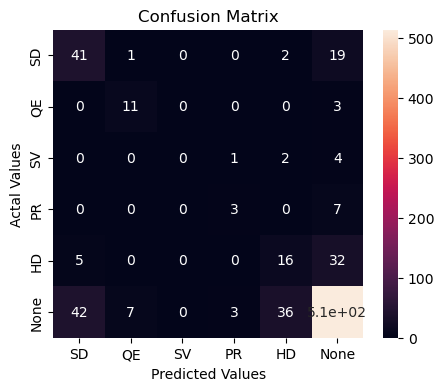

==============multimodal===============
              precision    recall  f1-score   support

          SD       0.48      0.65      0.55        63
          QE       0.53      0.71      0.61        14
          SV       0.00      0.00      0.00         8
          PR       0.43      0.25      0.32        12
          HD       0.29      0.45      0.35        62
        None       0.89      0.82      0.85       601

   micro avg       0.76      0.76      0.76       760
   macro avg       0.44      0.48      0.45       760
weighted avg       0.79      0.76      0.77       760
 samples avg       0.76      0.76      0.76       760



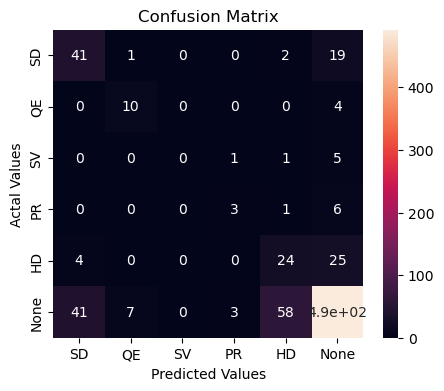

==============video===============
              precision    recall  f1-score   support

          SD       0.47      0.63      0.54        63
          QE       0.53      0.71      0.61        14
          SV       0.00      0.00      0.00         8
          PR       0.67      0.17      0.27        12
          HD       0.32      0.34      0.33        62
        None       0.88      0.86      0.87       601

   micro avg       0.78      0.77      0.77       760
   macro avg       0.48      0.45      0.43       760
weighted avg       0.78      0.77      0.77       760
 samples avg       0.78      0.78      0.78       760



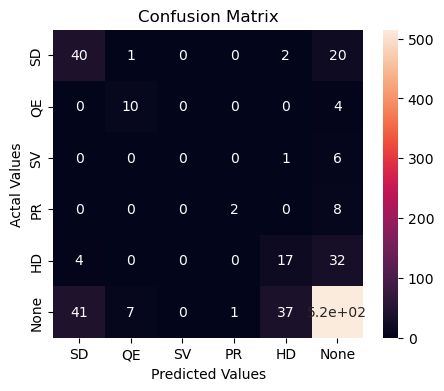

==============audio===============
              precision    recall  f1-score   support

          SD       0.48      0.67      0.56        63
          QE       0.53      0.71      0.61        14
          SV       0.00      0.00      0.00         8
          PR       0.67      0.17      0.27        12
          HD       0.26      0.34      0.29        62
        None       0.89      0.84      0.86       601

   micro avg       0.76      0.76      0.76       760
   macro avg       0.47      0.45      0.43       760
weighted avg       0.78      0.76      0.77       760
 samples avg       0.77      0.77      0.77       760



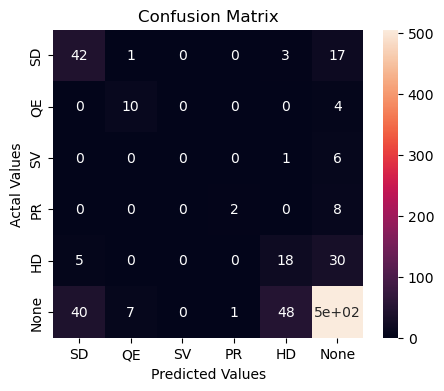

In [36]:
y_true = np.asarray(fin_targets)
txt_pred_n = np.asarray(txt_fin_outputs)
audio_pred_n = np.asarray(audio_fin_outputs)
video_pred_n = np.asarray(video_fin_outputs)
multimodal_pred_n = np.asarray(multimodal_fin_outputs)

results = [txt_pred_n, multimodal_pred_n, audio_pred_n, video_pred_n]
names = ["text", "multimodal", "video", "audio"]

none_true = np.maximum(0, 1 - y_true.sum(axis = 1).reshape(-1, 1))
y_true = np.concatenate([y_true, none_true], axis = 1)

for pred, n in zip(results, names):
    pred_final = np.where(pred > .2, 1, 0)
    none_pred = np.maximum(0, 1 - pred_final.sum(axis = 1).reshape(-1, 1))
    
    pred_final = np.concatenate([pred_final, none_pred], axis = 1)
    print("=============="  +n + "===============")
    print(classification_report(y_true, pred_final, target_names = ['SD', 'QE', 'SV', 'PR', 'HD', "None"], zero_division = False))
    cm = confusion_matrix(np.argmax(y_true, axis = 1), np.argmax(pred_final, axis = 1))
    cm_df = pd.DataFrame(cm,
                     index = ['SD', 'QE', 'SV', 'PR', 'HD', 'None'], 
                     columns = ['SD', 'QE', 'SV', 'PR', 'HD', 'None'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [16]:
def explore_tresh_comparison(true_model_1, pred_model_1, true_model_2, pred_model_2):
    tresh = np.linspace(pred_model_1.min()-.1,pred_model_1.max()+.1,50)
    out = [(
        np.subtract(precision_score(true_model_1, np.where(pred_model_1>t,1,0), zero_division = False), precision_score(true_model_2, np.where(pred_model_2>t,1,0), zero_division = False)),
        np.subtract(recall_score(true_model_1, np.where(pred_model_1>t,1,0)), recall_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(f1_score(true_model_1, np.where(pred_model_1>t,1,0)), f1_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(accuracy_score(true_model_1, np.where(pred_model_1>t, 1, 0)), accuracy_score(true_model_2, np.where(pred_model_2>t, 1, 0))),
        np.subtract(np.where(pred_model_1>t,1,0).sum() / pred_model_1.shape[0], np.where(pred_model_2>t,1,0).sum() / pred_model_2.shape[0]),
        true_model_1.sum()/true_model_1.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out

# COMPARISON MULTI-MODAL VS. TEXT (POSITIVE VALUES ARE BETTER MULTI MODAL PERFORMANCES)

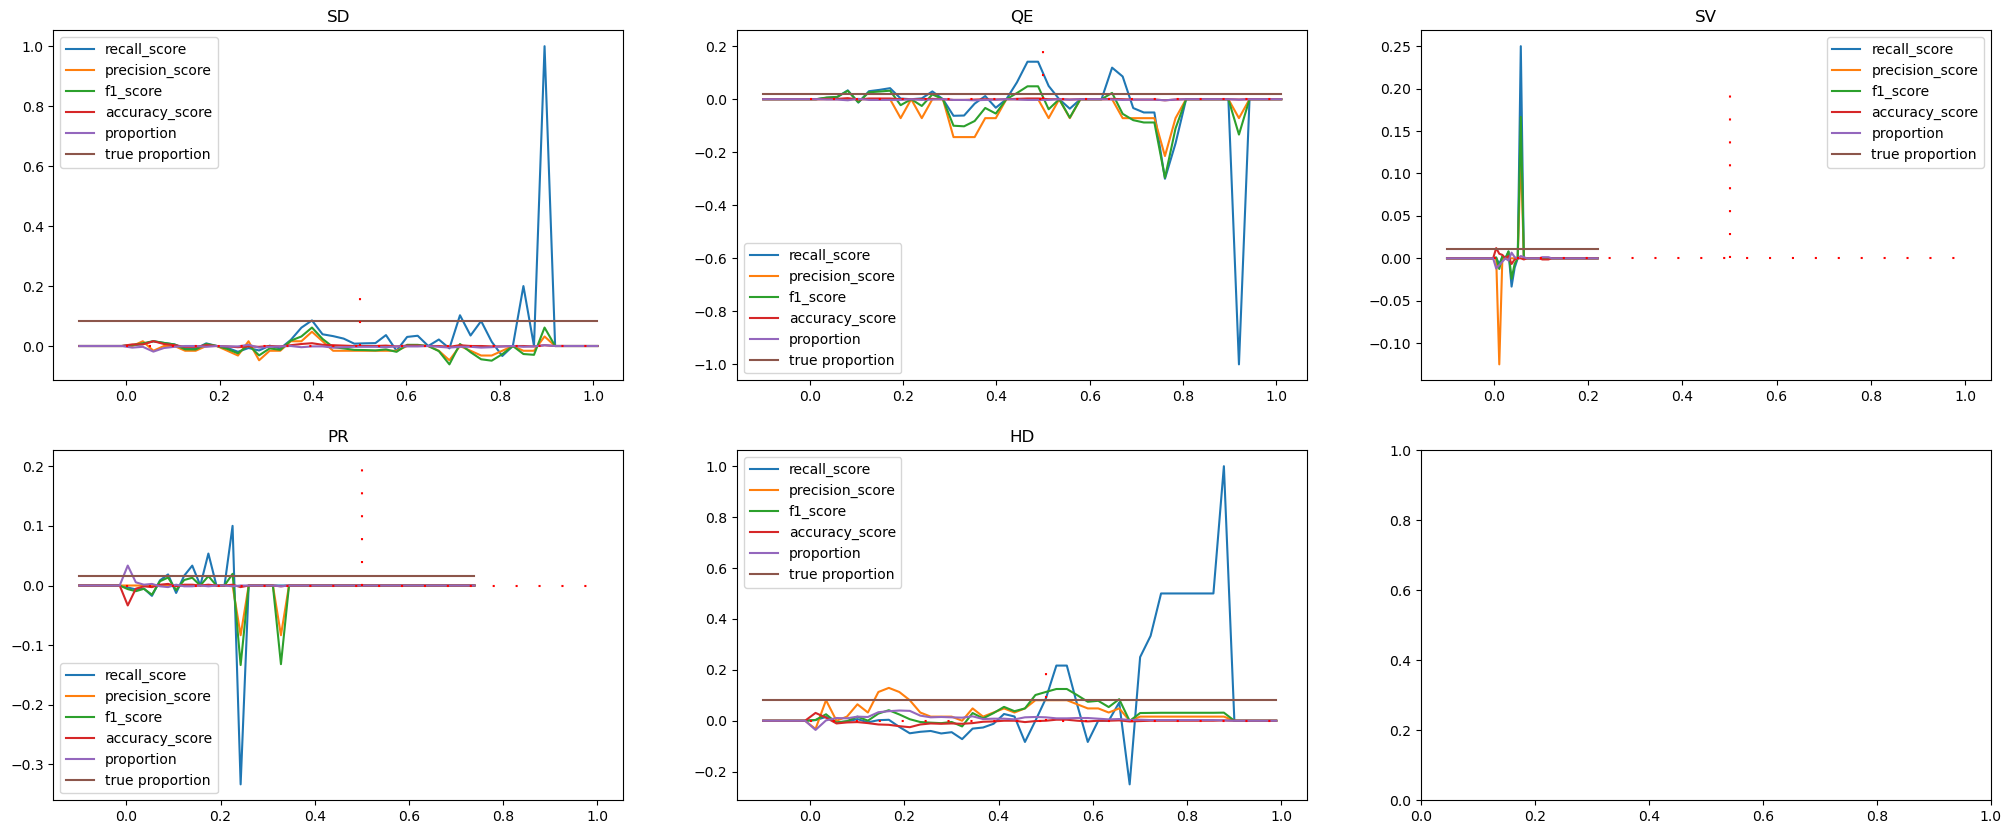

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh_comparison(y_true[:,i], multimodal_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

# COMPARISON AUDIO+TEXT VS. TEXT (POSITIVE VALUES -> AUDIO + TEXT BETTER)

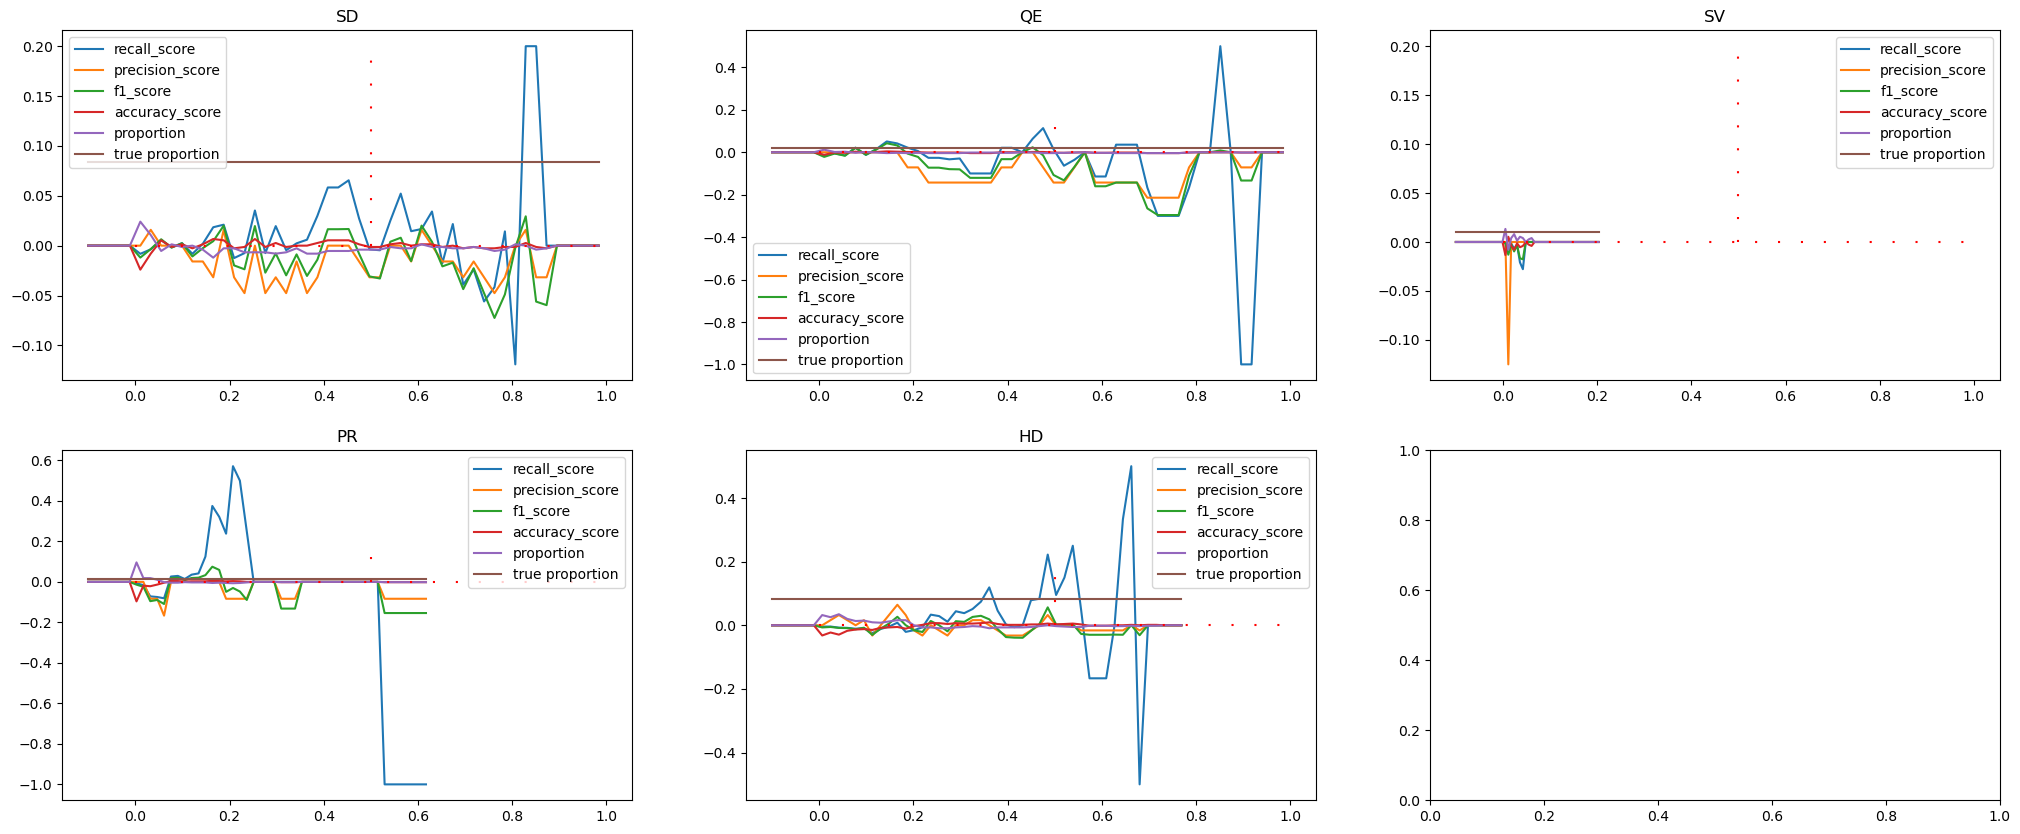

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh_comparison(y_true[:,i], audio_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

# COMPARISON VIDEO + TEXT VS. TEXT (positive is video + text > text)

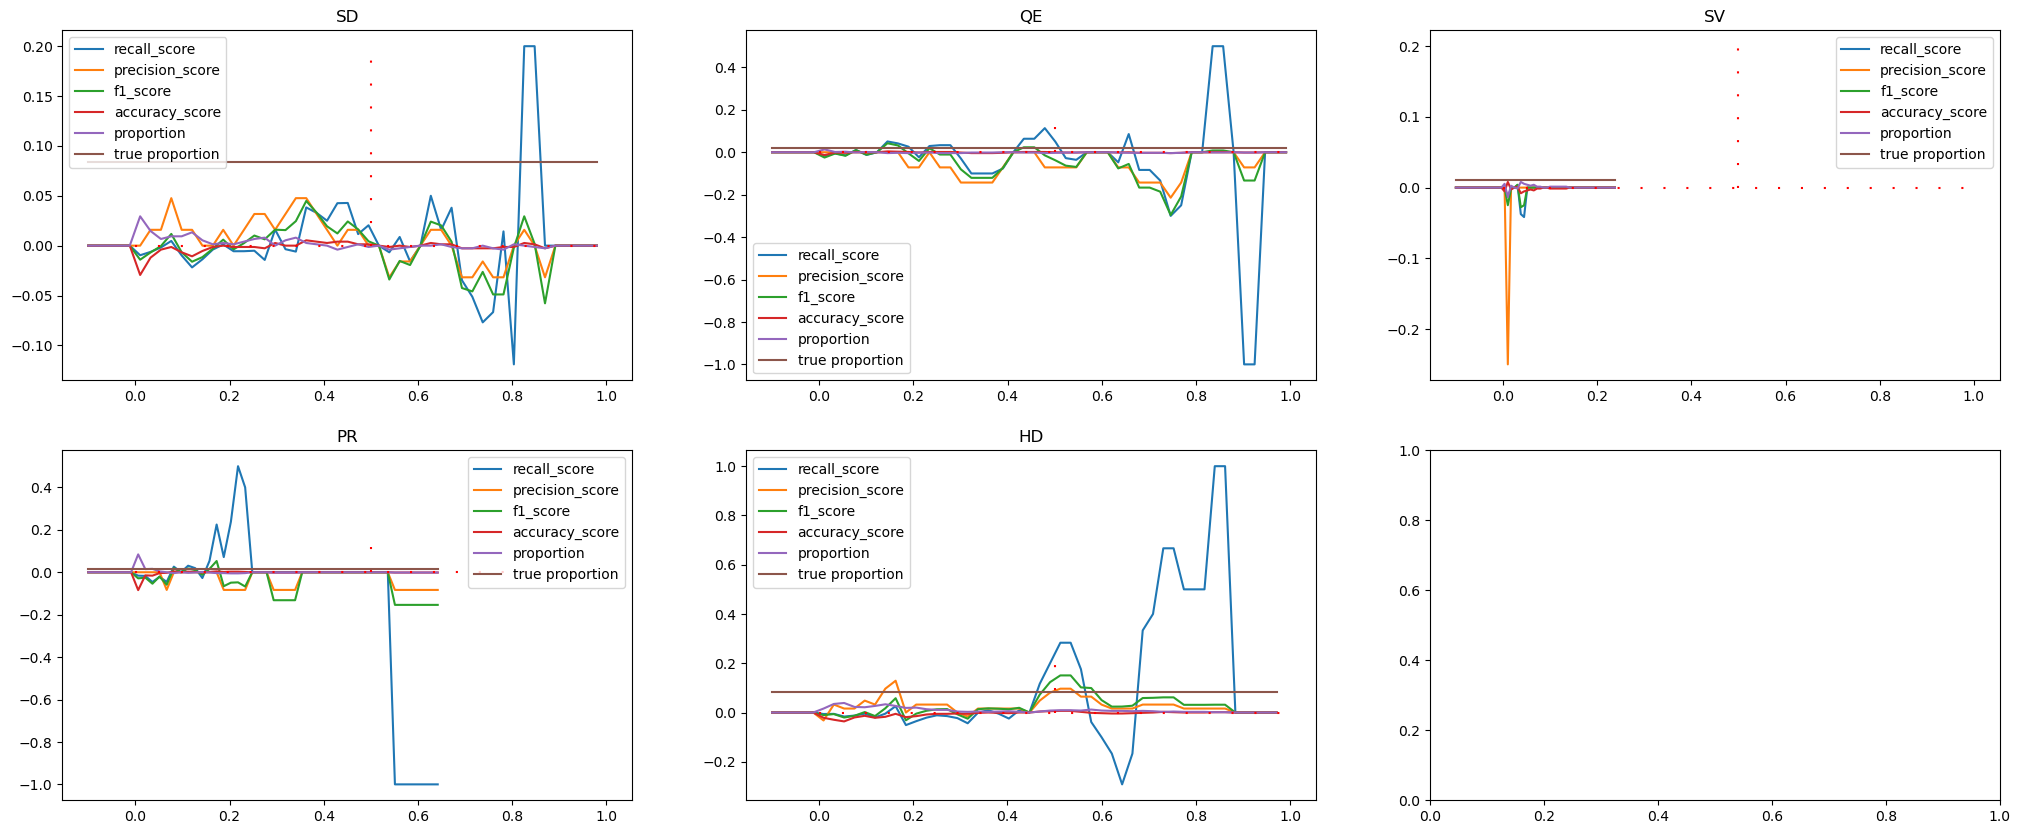

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh_comparison(y_true[:,i], video_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

# SINGLE MODEL PERFORMANCE

In [23]:
def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        precision_score(true, np.where(pred>t,1,0), zero_division = False),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['precision_score', 'recall_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh)
    return out

### TEXT

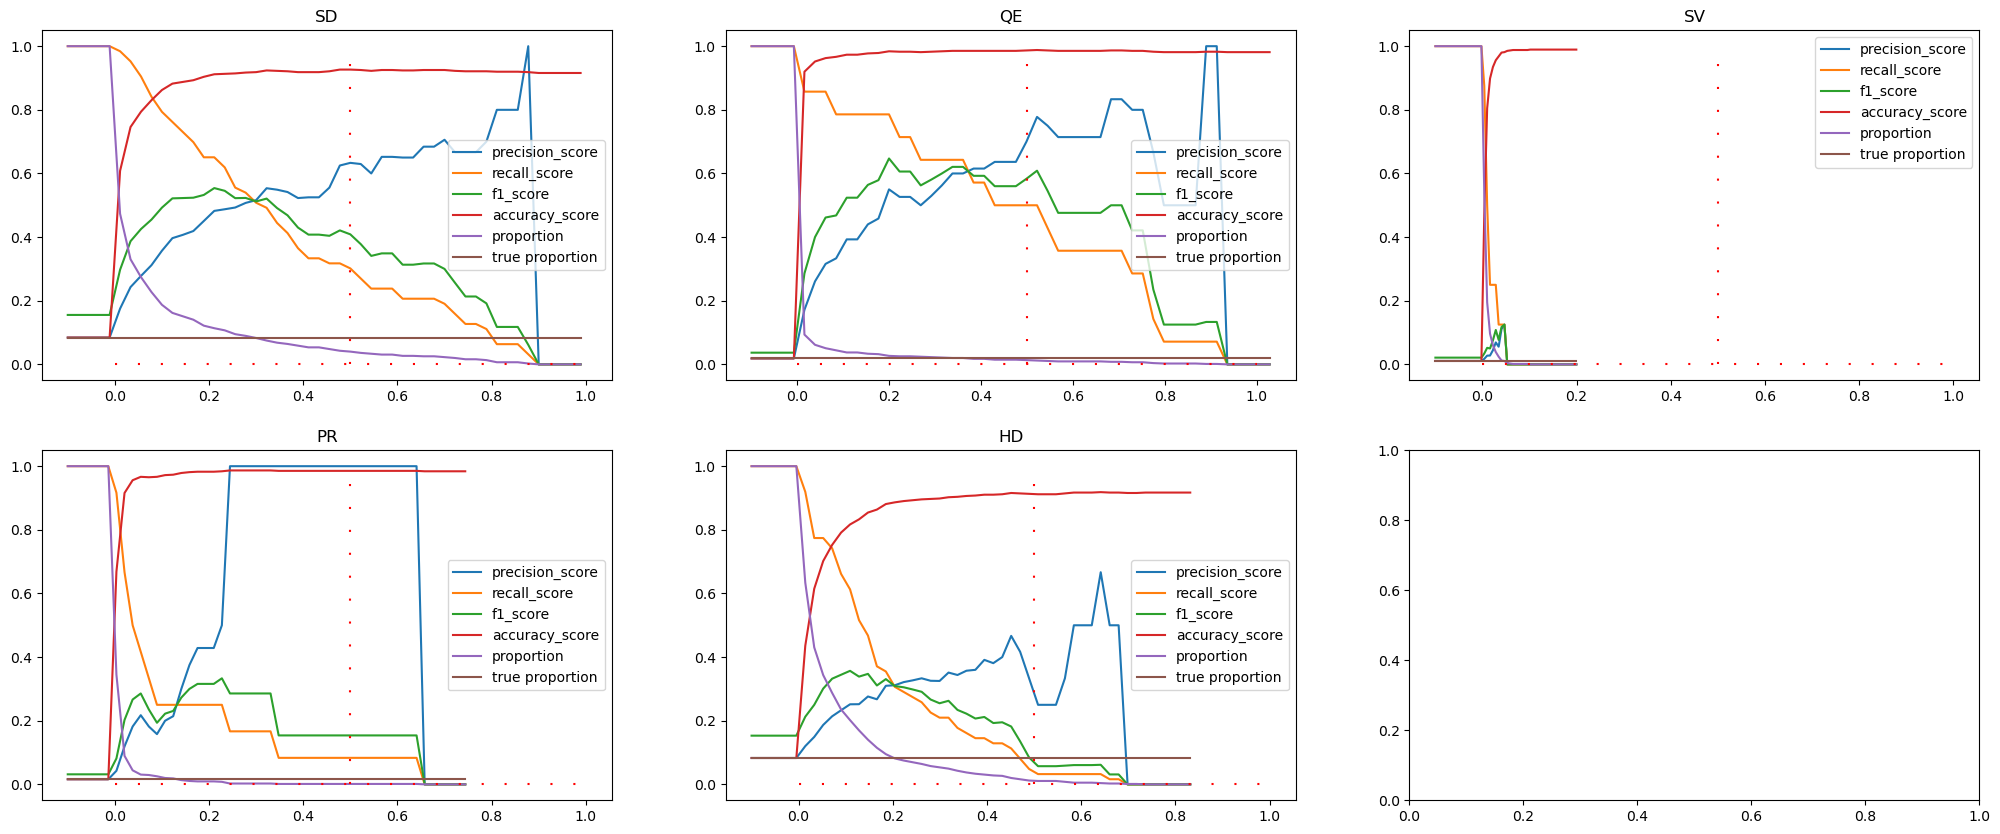

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))

# MULTI MODAL

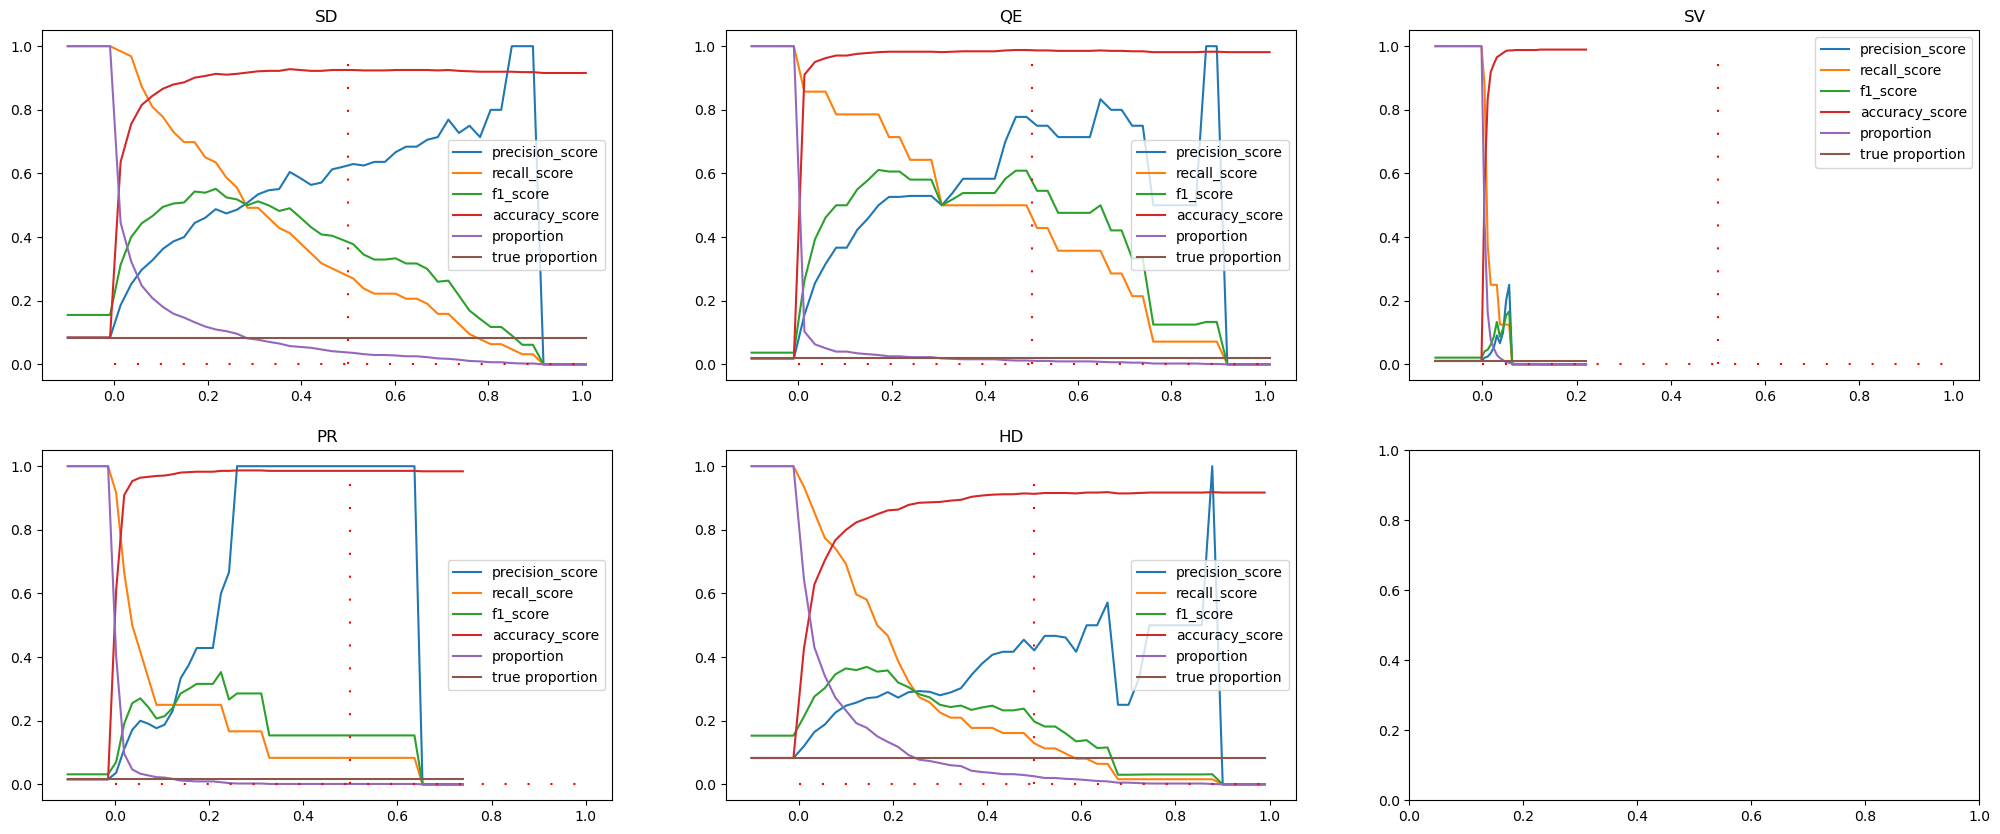

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], multimodal_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))

# AUDIO

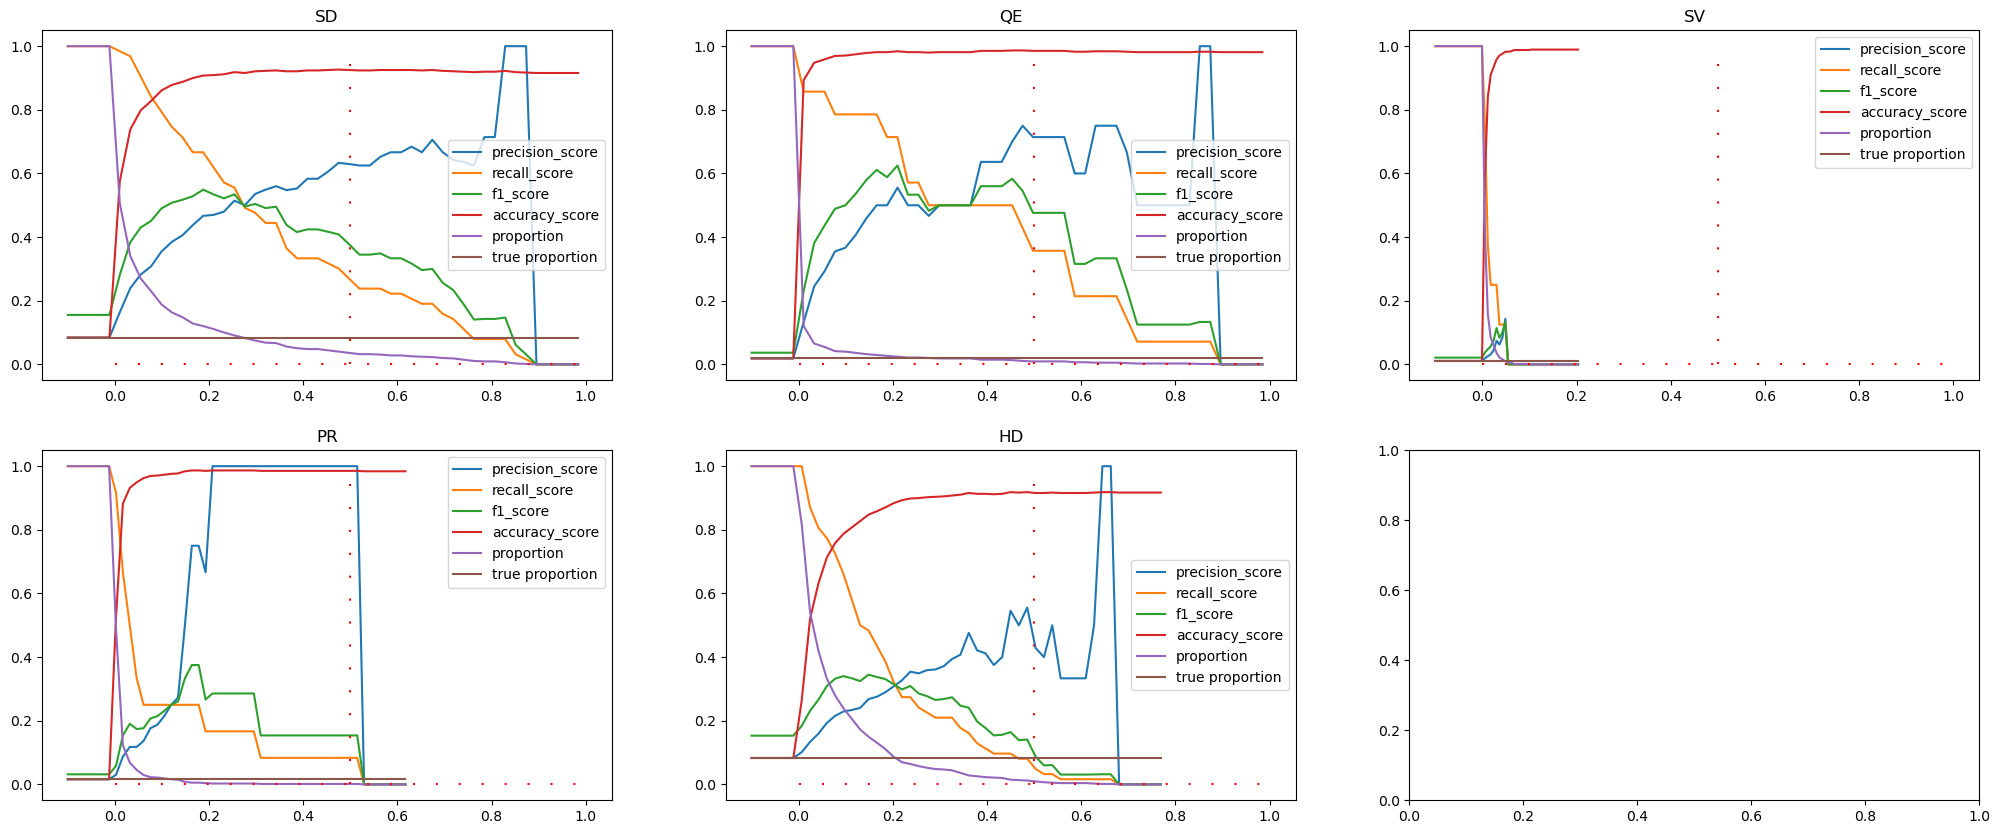

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], audio_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))

# VIDEO

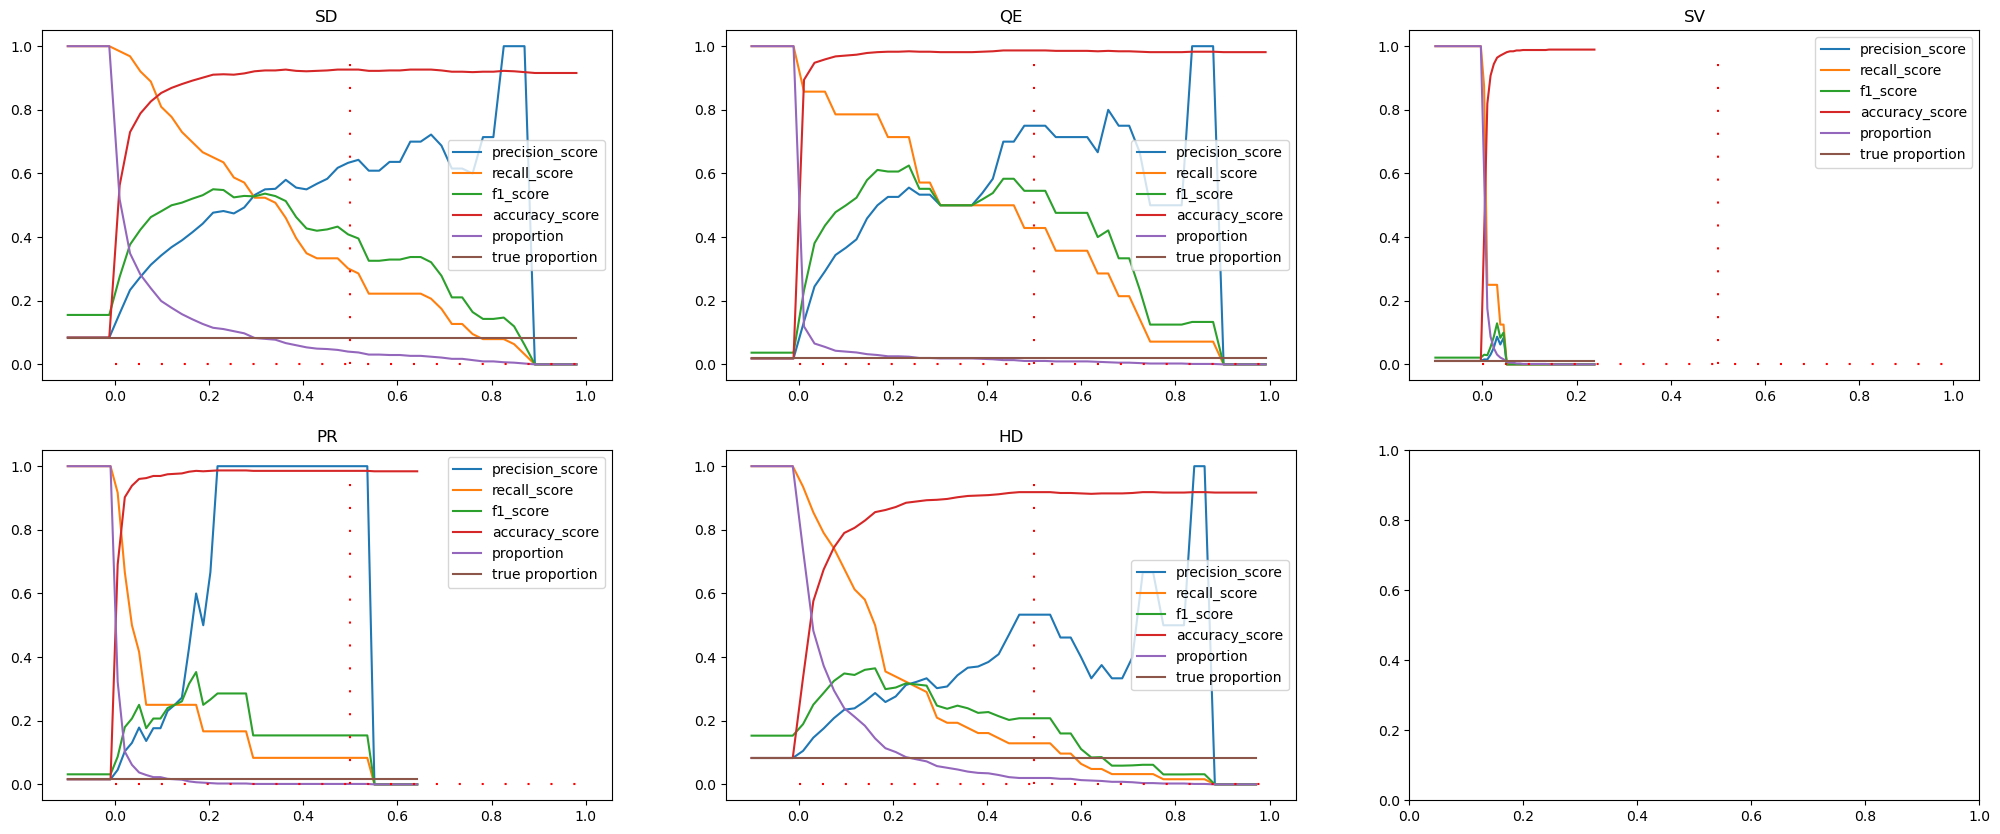

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], video_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))